<a href="https://colab.research.google.com/github/SichenPa221/ATSI/blob/main/fewshot_remote_sensing_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet de classification "few shot" d'images de télédétection

## Objectifs

Les approches d'apprentissage, en particulier celles utilisant des réseaux profonds, réclament une grande quantité de données. Cette condition n'est pas toujours possible à satisfaire pour certains problèmes réels, et se pose la question de concevoir des prédicteurs avec un nombre limité de données, mais en utilisant d'autres ressources.

Il s'agit d'un problème classique d'apprentissage ayant donné lieu à un très grand nombre d'approches pour le résoudre (https://arxiv.org/abs/2205.06743). Dans le cadre du projet, on se concentrera sur l'utilisation des réseaux de neurones pré-appris à adapter.


## Position du problème

La formulation classique du problèmes est exprimée par l'expression "K-way, N-shot" qui indique que l'on cherche à construire une démarche d'apprentissage d'un classifieur à $K$ classes à parire de $N$ données.

L'évaluation de ce genre de stratégie consiste à
1. échantillonner les exemples d'apprentissage
1. réaliser l'apprentissage ou l'adaptation du classifieur à partir de ces données
1. évaluer le classifieur sur une base de test
1. recommencer la séquence et agréger les performances

Dns le cadre du projet, on dispose d'un certain nombre de réseaux de neurones profonds pré-appris sur des bases de données variées, comme ImageNet. Ces réseaux peuvent être utilisés comme extracteurs de caractéristiques d'images génériques.

Les questions que l'on se peut se poser sont les uivantes:
- Peut-on avec ces réseaux apprendre sur quelques images un nouveau classifieur pour de nouvelles classes. Typiquement, apprendre avec 5, 10, 50... exemples par classe.
- Peut-on adapter/préparer le réseau au type de données à traiter (ici des images aériennes)

## Travail

1. Récupérer les données du problème (code ci-dessus): il s'agit d'images aériennes d'un département français (ici l'Essonne). Des images d'un deuxième départment sont fournies (Haute Garonne) pour un éventuel ré-apprentissage. Les données proviennent de la base FLAIR (https://ignf.github.io/FLAIR/index_fr.html).
1. Repérer et charger des réseaux candidats pour l'extraction de caractéristiques (un exemple dans les codes ci-dessous)
1. Adapter le réseau à partir de quelques exemples: il faudra modifier le dataloader.
1. Réapprendre si besoin le réseau sur d'autres données pour préparer l'adaptation.
1. Mettre en place une démarche d'évaluation d'un apprentissage *k-shot-5-way*.Il faudra faire tourner les exemples d'apprentissage dans les dataloaders.
1. Comparer les résultats pour diverses configurations (nombre d'exemples, nature des réseaux pré-appris, réapprentissage etc.)


## Ressources disponibles
- Bibliothèques de réseaux et de datasets:
  - torchvision (https://pytorch.org/vision/stable/index.html)
  - torchgeo (https://github.com/microsoft/torchgeo)
  - hugging face (https://huggingface.co/models)
  - timm (https://timm.fast.ai/)
  - ...
- Données FLAIR
  - Images de l'Esonne pour évaluer la démarche few-shot: répertoire `D091_2021`
  - Images de la Haute-Garonne pour un complément d'apprentissage: répertoire  `D031_2019`
  - Des fichiers de labels correspondant dans le répertoire `Labels` avec comme classes

  >```
  classnames = {
        0: "Anthropized",
        1: "Natural",
        2: "Vegetation",
        3: "Agricultural",
        4: "Herbeceous"
    }
    ```

# Quelques bouts de code utiles

## Connexion au drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# CHANGER ICI!!
import os
os.chdir('/content/drive/MyDrive/teaching/ENSTA/2024')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/teaching/ENSTA/2024'

## Bibliothèques utiles

In [ ]:
import torch

# Pour trouver de nouveaux réseaux
!pip -q install timm
!pip -q install torchgeo

# Pour l'évaluation
!pip -q install torchmetrics


In [ ]:
# Permet de vérifier si vous avez accès à un GPU
!nvidia-smi

Wed Dec 20 07:28:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip -q install gdown

# Téléchargement des données: prend environ 1min15 avec un bon internet
# Get Images
!gdown https://drive.google.com/uc?id=1xARXjWW6YyTfkh8oHkG5ZAYFScKXkrwL
!unzip -q FLAIR1_IGN.zip
!rm FLAIR1_IGN.zip
# Get Labels
!gdown https://drive.google.com/drive/folders/1bSi5XJ8jlnJdpNC9kmtkGqkzZ4P2aKst --folder

Downloading...
From: https://drive.google.com/uc?id=1xARXjWW6YyTfkh8oHkG5ZAYFScKXkrwL
To: /content/drive/MyDrive/teaching/ENSTA/2024/FLAIR1_IGN.zip
100% 1.47G/1.47G [00:08<00:00, 174MB/s] 
Retrieving folder list
Processing file 1mbKxEbTB6sUJwlsjI5UXKxddIvmWGibm D031_2019_test_labels.txt
Processing file 19TXfF-oo7xhC4P-bMNCqwOcgrXYxbZZS D031_2019_train_labels.txt
Processing file 1Pjv6PIBiFcN6PjpCL3-xBvGpxS7Zz1kG D091_2021_test_labels.txt
Processing file 1gam0BpfL-2d296dcFnQNdCADJZuTpmtk D091_2021_train_labels.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1mbKxEbTB6sUJwlsjI5UXKxddIvmWGibm
To: /content/drive/MyDrive/teaching/ENSTA/2024/Labels/D031_2019_test_labels.txt
100% 6.11k/6.11k [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=19TXfF-oo7xhC4P-bMNCqwOcgrXYxbZZS
To: /content/drive/MyDrive/teaching/ENSTA/2024/Labels/D031_2019_train_labels.txt
100% 14

In [ ]:
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, ConcatDataset

from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics import ConfusionMatrix, MetricCollection, Accuracy, Precision, Recall

In [ ]:
batch_size = 16
num_workers = 2
nums_epoch = 5

In [ ]:
import timm
from torchgeo.models import ResNet50_Weights

weights = ResNet50_Weights.SENTINEL2_RGB_SECO
class_num = 5
in_chans = weights.meta["in_chans"]

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("resnet50", in_chans=in_chans, num_classes=class_num).cuda()
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

Downloading: "https://huggingface.co/torchgeo/resnet50_sentinel2_rgb_seco/resolve/main/resnet50_sentinel2_rgb_seco-018bf397.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_seco-018bf397.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 166MB/s]


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:

classnames = {
        0: "Anthropized",
        1: "Natural",
        2: "Vegetation",
        3: "Agricultural",
        4: "Herbeceous"
    }

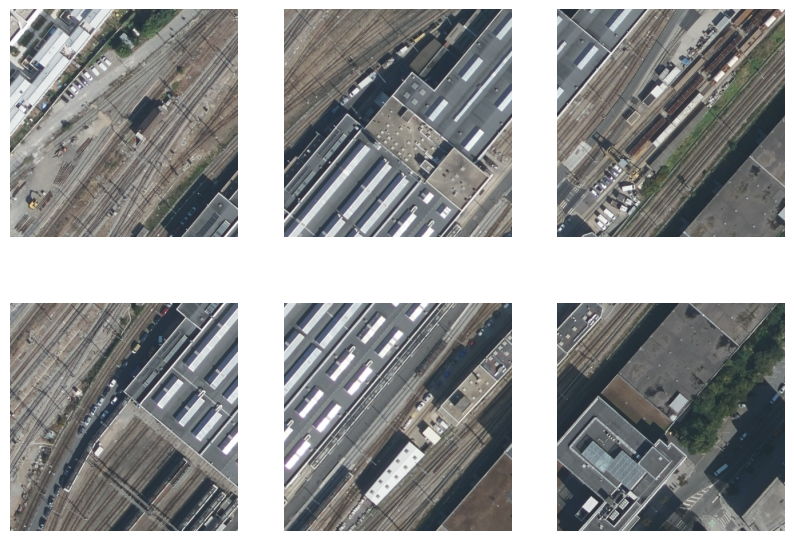

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def pil_loader(path):
    '''
    Ref:
    https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
    '''
    with open(path, 'rb') as f: # equivalent de f.read de rasterio
       img = Image.open(f)
       return img.convert('RGB')

# Liste des chemins vers les 6 images en ESSONNE
image_paths = [
    'FLAIR1_IGN/D091_2021/IMG_060404.png',
    'FLAIR1_IGN/D091_2021/IMG_060405.png',
    'FLAIR1_IGN/D091_2021/IMG_060406.png',
    'FLAIR1_IGN/D091_2021/IMG_060414.png',
    'FLAIR1_IGN/D091_2021/IMG_060415.png',
    'FLAIR1_IGN/D091_2021/IMG_060416.png'
]

# Création d'une figure avec 2 lignes et 3 colonnes pour afficher 6 images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Flatten pour itérer sur les sous-graphiques
axes = axes.flatten()

# Chargement et affichage des images
for i, path in enumerate(image_paths):
    img = pil_loader(path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Désactiver les axes

plt.show()

In [ ]:
class FlairDataset(Dataset):
    # Custom dataset for the data loader
    def __init__(self, txt_file, trsf):
        with open(txt_file, 'r') as f:
            lines = f.read().splitlines()
        self.data = []
        for line in lines:
            path, label, _ = line.split("\t")

            self.data.append((path, label))
        self.trsf = trsf
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        path = path.replace('/FLAIR1_IGN/', './FLAIR1_IGN/')
        image = self.trsf(pil_loader(path))
        return idx, image, label

In [ ]:
train_trsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=63/255)
])
test_trsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
])

In [ ]:
train_paths = "./Labels/D031_2019_train_labels.txt"
test_paths ="./Labels/D031_2019_test_labels.txt"

# Pour les données d'apprentissage
train_dataset = FlairDataset(txt_files=[train_paths], trsf=train_trsf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                num_workers=num_workers)

# Pour les données de test
test_dataset = FlairDataset(txt_files=[test_paths], trsf=test_trsf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                       num_workers=num_workers)

# Concatene les données d'apprentissage et de test (pour le few shot)
full_dataset = FlairDataset(txt_files=[train_paths,test_paths], trsf=test_trsf)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=num_workers)
labels = np.array(full_dataset.labels)

## Fonction d'apprentissage (à coder)

Fonction générique **A ECRIRE**.

A utiliser pour chaque étape d'apprentissage "few shot".


In [ ]:
def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):

    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []

    # iterate over epochs
    for epoch in range(num_epochs):
      print("Epoch {}".format(epoch))

      # Learning step

    return model, train_perf, test_perf, train_losses

